In [1]:
# Import the needed modules
import emcee                                    # MCMC package
import numpy as np                              # Math package
import matplotlib.pyplot as plt                 # Plotting package
import pandas as pd                             # I/O package
from scipy.stats import norm, uniform, gamma    # Random distributions Packages

In [2]:
# Set a randomizer seed for repeatability
np.random.seed(5731)

In [3]:
# Start by loading in the data
data = pd.read_csv('bv_rhk_data.csv', delimiter=',')

# Print a summary
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cluster_Name  203 non-null    object 
 1   Cluster       203 non-null    int64  
 2   (B-V)         203 non-null    float64
 3   Log(R_HK)     203 non-null    float64
 4   Age_Myr       203 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 8.1+ KB


In [4]:
# Calculate stats on the r variable
r_stats = data.groupby('Cluster_Name')['Log(R_HK)'].agg(['mean', 'std'])
cluster_age = data.groupby('Cluster_Name')['Age_Myr'].agg('mean')

# Separate variables to be handed to the MCMC model
r = r_stats['mean'].values
err = r_stats['std'].values
t = np.log10(cluster_age.values)


In [5]:
# Build functions to be handed to the MCMC chain

# Normal Distribution
def log_norm(x, mu, var):
    # Compute the exponent of the normal distribution
    lnp = -(0.5/var)*np.square(x-mu)

    # Return sum of all log probabilities
    return np.sum(lnp)

# Uniform Distribution
def log_uniform(x, min, max):
    # If x is not within (min, max), return negative infinity
    if x <= min or x >= max:
        return -np.Inf
    
    # Otherwise, return a constant (I chose 0)
    return 0
    
# Gamma Distribution
def log_gamma(x, a, b):
    # First things first: If input value is non-positive, return negative infinity
    if x <= 0:
        return -np.Inf
    
    # Now compute the log probability for a positive input value
    lnp = (a-1)*np.log(x) - b*x

    # Return log probability
    return lnp

# The total probability function that will be passed to the MCMC model
def log_prob(params, x, y, xerr, intmin, intmax, slopemean, slopevar, a, b):
    # Extract the parameters from this iteration
    beta0, beta1, lam = params

    # Compute the expected value of y
    xb = beta0 + beta1*x

    # Probability of beta0
    lnint = log_norm(beta0, slopemean, slopevar)

    # Probability of beta1 (must be non-positive)
    lnslope = log_uniform(beta1, intmin, intmax)

    # Probability of lambda
    lnvar = log_gamma(lam, a, b)

    # Probability of y given xb and error on x
    lny = log_norm(y, xb, np.square(beta1*xerr) + 1/lam)

    # Return the sum of the log probabilities
    lnp = lnint + lnslope + lnvar + lny
    return lnp

In [6]:
# Set up parameters for the MCMC chains
ndims = 3
nwalkers = 8
nburnin = 5000
nsim = 100000

# Prior parameters
a = 1.5 # Gamma distribution is unit information prior
b = 1.0
intmin = -10
intmax = 0
slopemean = 0
slopevar = 1000

# Alternative prior parameters
a2 = 1.0
b2 = 1.0
intmin2 = -100
intmax2 = 100
slopemean2 = 0
slopevar2 = 1

# Initial guesses for beta0, beta1, lambda
initb0 = np.abs(norm.rvs(slopemean, np.sqrt(slopevar), size=[nwalkers, 1]))
initb1 = uniform.rvs(intmin, intmax-intmin, size=[nwalkers, 1])
initlam = gamma.rvs(a, 1/b, size=[nwalkers, 1])

# Combine initial parameters
init = np.concatenate([initb0, initb1, initlam], axis=1)

In [7]:
# Set up the different chains and run them
samplerA = emcee.EnsembleSampler(nwalkers, ndims, log_prob, args=[r, t, 0, intmin, intmax, slopemean, slopevar, a, b]) # No error accounted for
samplerB = emcee.EnsembleSampler(nwalkers, ndims, log_prob, args=[r, t, err, intmin, intmax, slopemean, slopevar, a, b]) # Error accounted for
samplerC = emcee.EnsembleSampler(nwalkers, ndims, log_prob, args=[r, t, err, intmin2, intmax2, slopemean2, slopevar2, a2, b2]) # Weird priors

# First iterations are for burn in
print('Burn in for model A')
burninA = samplerA.run_mcmc(init, nburnin, progress=True)
samplerA.reset()
print('Burn in for model B')
burninB = samplerB.run_mcmc(init, nburnin, progress=True)
samplerB.reset()
print('Burn in for model C')
burninC = samplerC.run_mcmc(init, nburnin, progress=True)
samplerC.reset()

# Run the emcee chain
print('Running model A')
samplerA.run_mcmc(burninA, nsim, progress=True);
print('Running model B')
samplerB.run_mcmc(burninB, nsim, progress=True);
print('Running model C')
samplerC.run_mcmc(burninC, nsim, progress=True);

Burn in for model A


100%|██████████| 5000/5000 [00:01<00:00, 3301.81it/s]


Burn in for model B


100%|██████████| 5000/5000 [00:01<00:00, 3166.27it/s]


Burn in for model C


100%|██████████| 5000/5000 [00:01<00:00, 3186.60it/s]


Running model A


100%|██████████| 100000/100000 [00:29<00:00, 3348.79it/s]


Running model B


100%|██████████| 100000/100000 [00:32<00:00, 3099.22it/s]


Running model C


100%|██████████| 100000/100000 [00:32<00:00, 3090.37it/s]


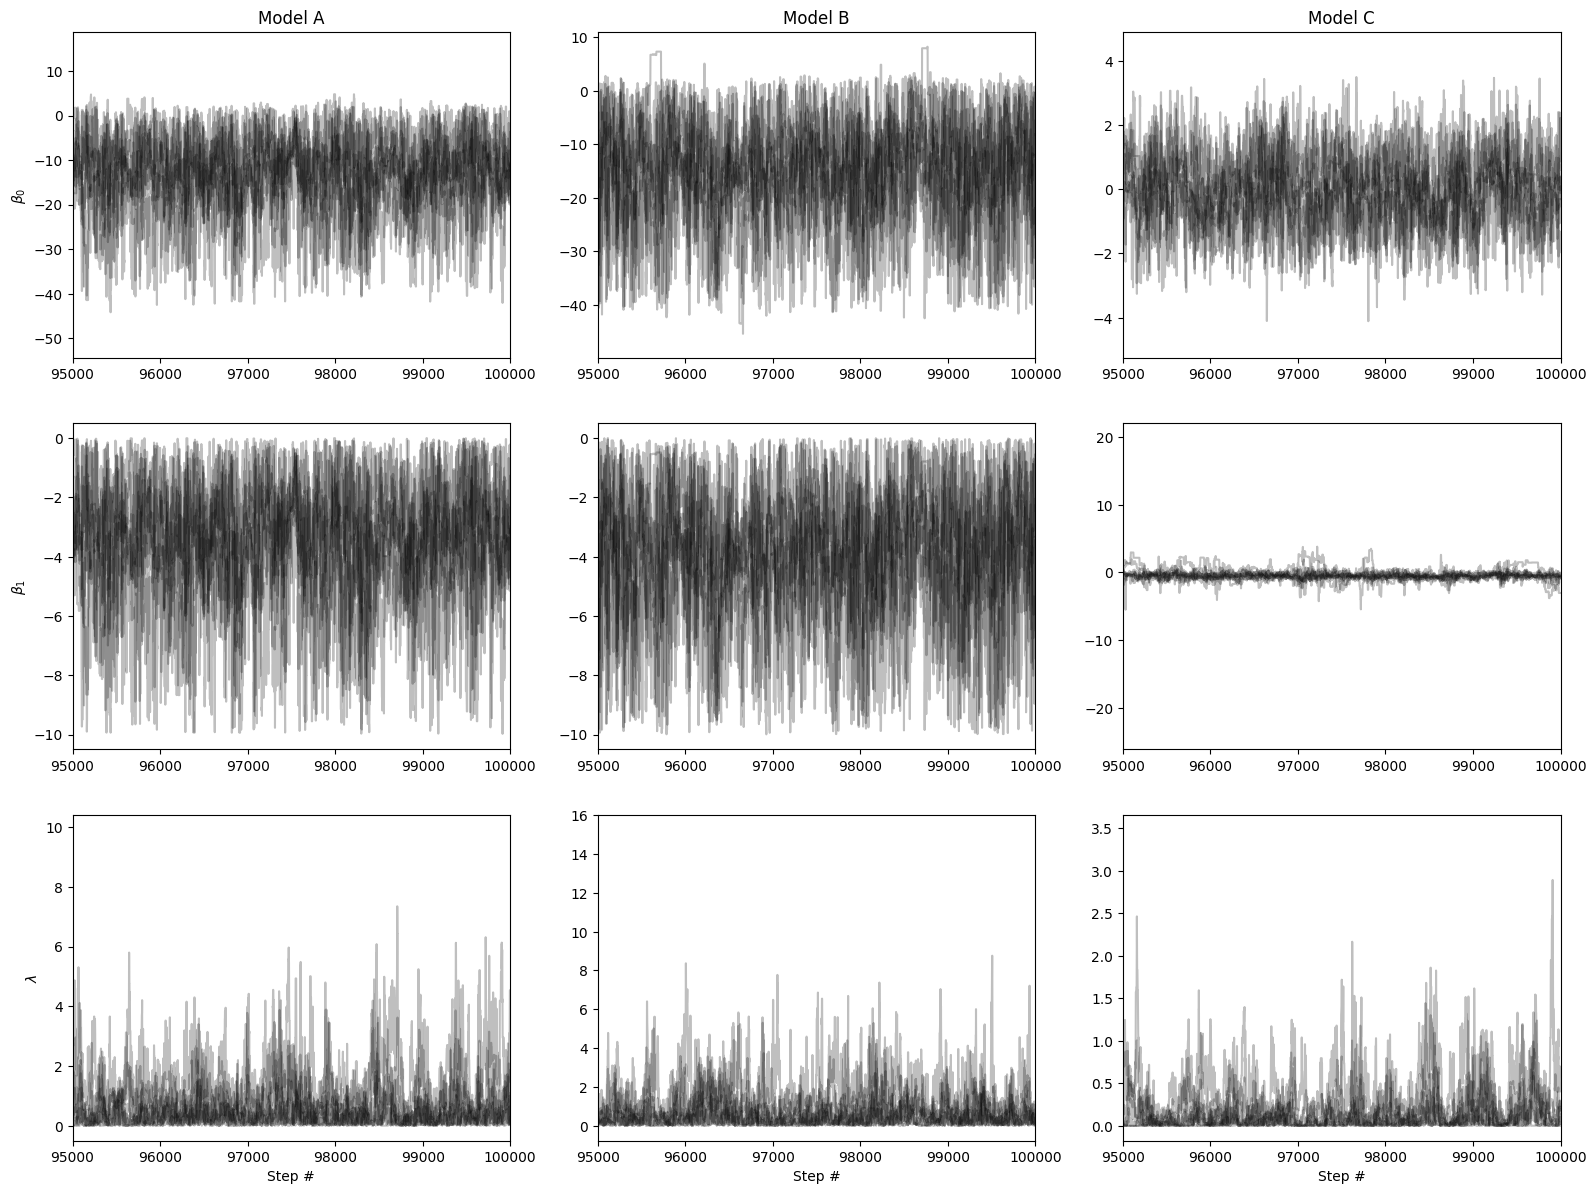

In [8]:
# Check convergence
# Set up figure (nrows x ncols)
nrows=3
ncols=3
fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_figheight(nrows*fig.get_figheight())
fig.set_figwidth(ncols*fig.get_figwidth())

# Extract MCMC chains
samplesA = samplerA.get_chain()
samplesB = samplerB.get_chain()
samplesC = samplerC.get_chain()
samples = [samplesA, samplesB, samplesC]

# Add variable/MCMC chain labels
headers = ['Model A', 'Model B', 'Model C']
labels = [r"$\beta_0$", r"$\beta_1$", r"$\lambda$"]

# Plotting time
# Iterate over chains
ax0 = axes[:, 0]
for i in range(ncols):
    axs = axes[:, i]
    sample = samples[i]

    # Iterate over variables
    for j in range(nrows):
        # Plot the last nburnin of each chain
        axs[j].plot(sample[:, :, j], color="black", alpha=0.25)
        axs[j].set_xlim(nsim-nburnin, nsim)
        ax0[j].set_ylabel(labels[j]) # Re-labels same thing for every chain, but its okay

    # Label x axes and give column headers
    axs[0].set_title(headers[i])
    axs[-1].set_xlabel("Step #");

In [ ]:
# Extract data from each of the walkers and combine into one chain
sampsA = np.reshape(samplesA, (nsim*nwalkers, ndims), order='F');
sampsB = np.reshape(samplesB, (nsim*nwalkers, ndims), order='F');
sampsC = np.reshape(samplesC, (nsim*nwalkers, ndims), order='F');
samps = [sampsA, sampsB, sampsC]

In [14]:
# Choose confidence interval bounds
prc = 68; lb = 16; ub = 84 # 68%
# prc = 95; lb = 2.5; ub = 97.5 # 95%

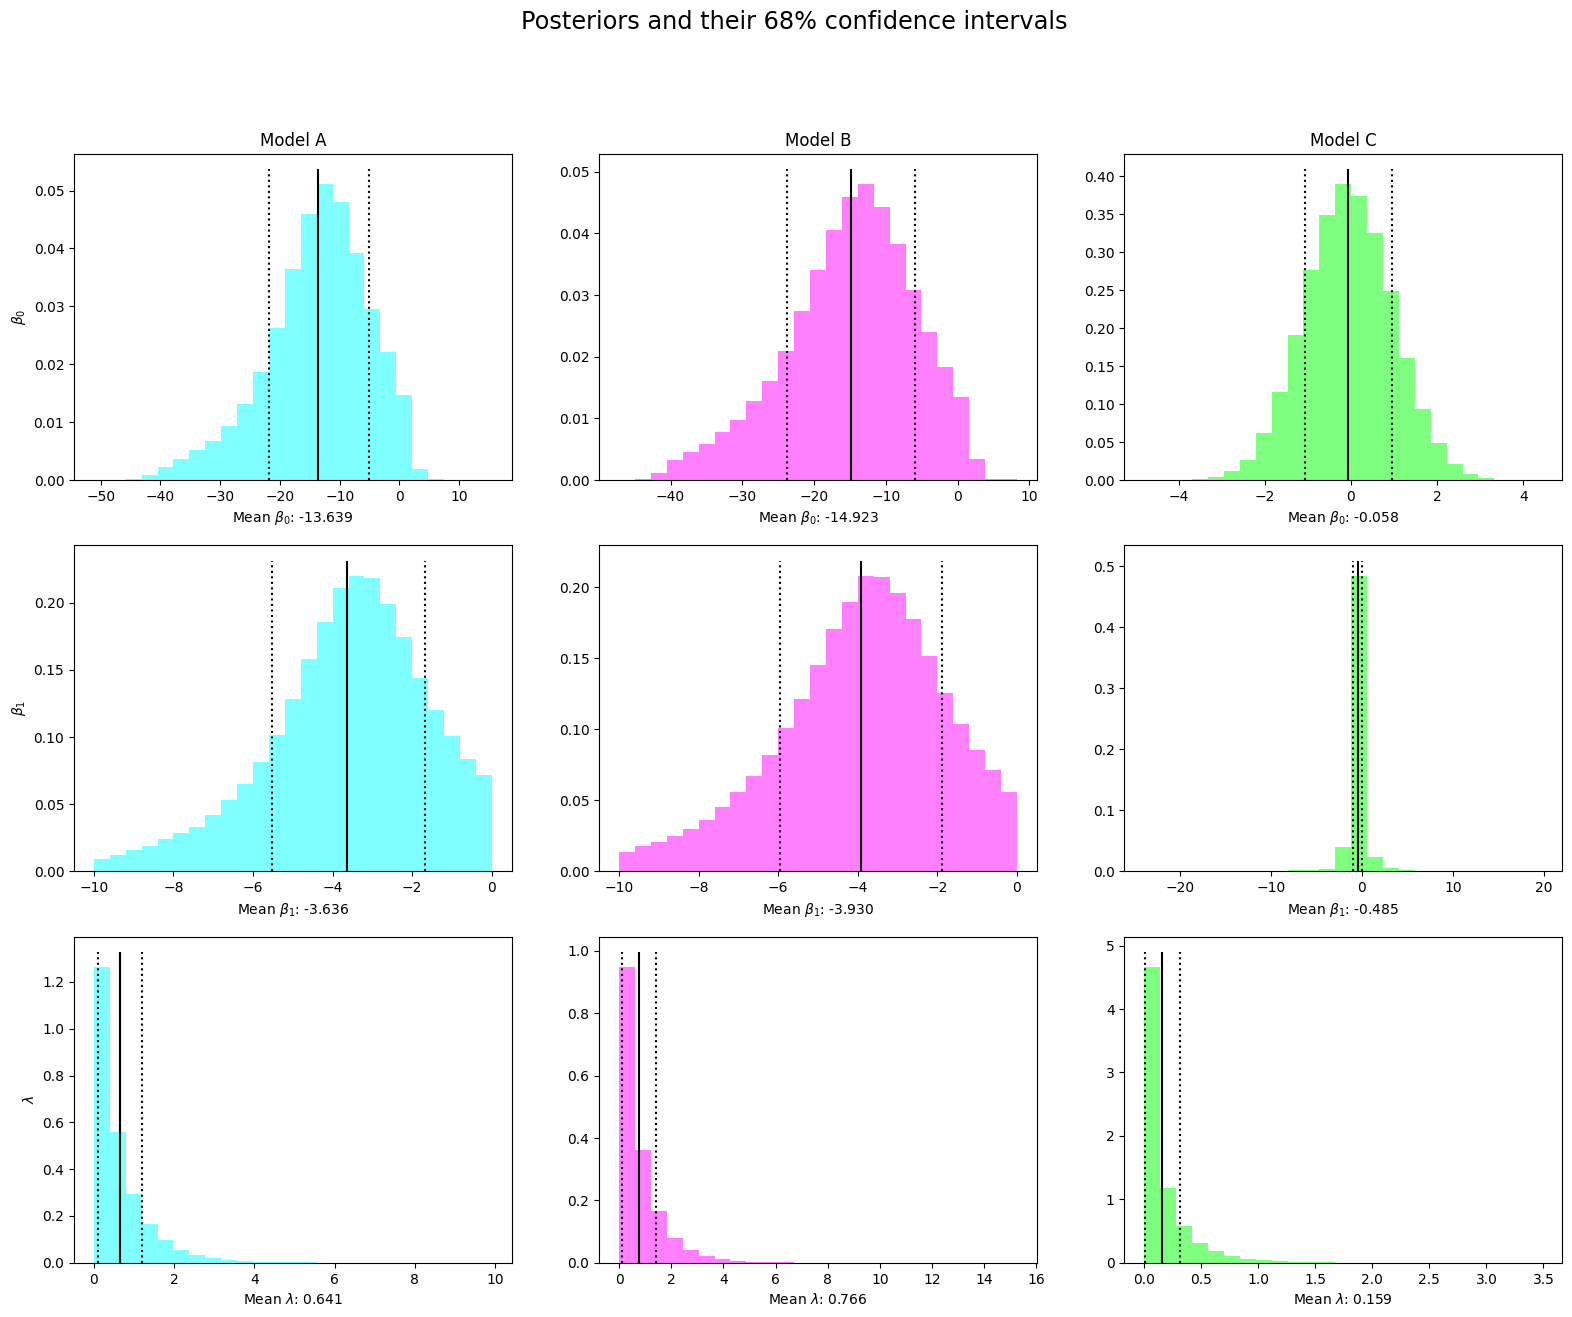

In [19]:
# Posteriors for the plots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols);
fig.suptitle(f'Posteriors and their {prc}% confidence intervals', fontsize='xx-large')
fig.set_figheight(nrows*fig.get_figheight())
fig.set_figwidth(ncols*fig.get_figwidth())

# Add variable/MCMC chain labels
headers = ['Model A', 'Model B', 'Model C']
labels = [r"$\beta_0$", r"$\beta_1$", r"$\lambda$"]

# Make each model have a different color!
colors = ['cyan', 'magenta', 'lime']

# Plot histograms
# Iterate over chains
ax0 = axes[:, 0]
for i in range(ncols):
    axs = axes[:, i]
    sample = samps[i]
    
    # Iterate over variables
    for j in range(nrows):
        # Plot histogram
        axs[j].hist(sample[:,j], density=True, bins=25, alpha=0.5, color=colors[i]);
        # Plot mean + confidence interval
        ylim = axs[j].get_ylim();
        axs[j].vlines(np.mean(sample[:,j]), ylim[0], ylim[1], color='black');
        axs[j].vlines([np.percentile(sample[:,j], lb), np.percentile(sample[:,j], ub)], ylim[0], ylim[1], color='black', linestyle='dotted');
        ax0[j].set_ylabel(labels[j])
        axs[j].set_xlabel(f'Mean {labels[j]}: {np.mean(sample[:,j]):.3f}')

    # Label x axes and give column headers
    axs[0].set_title(headers[i])

In [16]:
# Get the means and 95% confidence intervals for the 3 models
intA = np.array([np.mean(sampsA[:, 0]), np.percentile(sampsA[:, 0], lb), np.percentile(sampsA[:, 0], ub)]);
slopeA = np.array([np.mean(sampsA[:, 1]), np.percentile(sampsA[:, 1], lb), np.percentile(sampsA[:, 1], ub)]);
intB = np.array([np.mean(sampsB[:, 0]), np.percentile(sampsB[:, 0], lb), np.percentile(sampsB[:, 0], ub)]);
slopeB = np.array([np.mean(sampsB[:, 1]), np.percentile(sampsB[:, 1], lb), np.percentile(sampsB[:, 1], ub)]);
intC = np.array([np.mean(sampsC[:, 0]), np.percentile(sampsC[:, 0], lb), np.percentile(sampsC[:, 0], ub)]);
slopeC = np.array([np.mean(sampsC[:, 1]), np.percentile(sampsC[:, 1], lb), np.percentile(sampsC[:, 1], ub)]);

# Print out results
print(f'Model A\nIntercept = {intA[0]:.3f}\t{prc}% Conf. ({intA[1]:.3f}, {intA[2]:.3f})\nSlope = {slopeA[0]:.3f}\t{prc}% Conf. ({slopeA[1]:.3f}, {slopeA[2]:.3f})')
print(f'Model B\nIntercept = {intB[0]:.3f}\t{prc}% Conf. ({intB[1]:.3f}, {intB[2]:.3f})\nSlope = {slopeB[0]:.3f}\t{prc}% Conf. ({slopeB[1]:.3f}, {slopeB[2]:.3f})')
print(f'Model C\nIntercept = {intC[0]:.3f}\t{prc}% Conf. ({intB[1]:.3f}, {intC[2]:.3f})\nSlope = {slopeC[0]:.3f}\t{prc}% Conf. ({slopeC[1]:.3f}, {slopeC[2]:.3f})')

Model A
Intercept = -13.639	68% Conf. (-21.831, -5.164)
Slope = -3.636	68% Conf. (-5.529, -1.672)
Model B
Intercept = -14.923	68% Conf. (-23.774, -6.003)
Slope = -3.930	68% Conf. (-5.966, -1.875)
Model C
Intercept = -0.058	68% Conf. (-23.774, 0.953)
Slope = -0.485	68% Conf. (-0.938, -0.030)


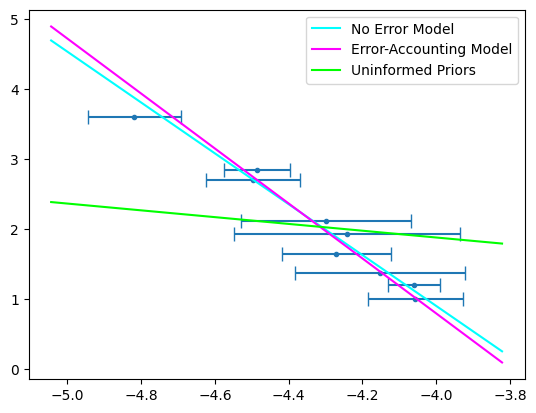

In [17]:
# Plot the results on top of the error bar plots
fig, ax = plt.subplots()

# Decide the x axes for the plots
xmin = np.min(r-err-0.1)
xmax = np.max(r+err+0.1)
x = np.array([xmin, xmax])

# Plot the model fits
ax.plot(x, intA[0]+slopeA[0]*x, label="No Error Model", color='cyan')
ax.plot(x, intB[0]+slopeB[0]*x, label="Error-Accounting Model", color='magenta')
ax.plot(x, intC[0]+slopeC[0]*x, label="Uninformed Priors", color='lime')

# Plot the 95% Intervals
# ax.fill_between(x, intA[1]+slopeA[2]*x, intA[2]+slopeA[1]*x, zorder=-2, color='cyan', alpha=0.5)
# ax.fill_between(x, intB[1]+slopeB[2]*x, intB[2]+slopeB[1]*x, zorder=-1, color='magenta', alpha=0.5)
# ax.fill_between(x, intC[1]+slopeC[2]*x, intC[2]+slopeC[1]*x, zorder=-1, color='lime', alpha=0.5)

# Plot the error bars
ax.errorbar(r, t, xerr=err, zorder=-3, fmt='.', capsize=5);

# Turn on the legend
ax.legend();